In [1]:
%matplotlib inline

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import reverse_geocoder
from os import listdir
from os.path import isfile, join
import numpy as np

### Inputs

In [7]:
### Returns an array of True/False if the coordinate is in a given state
### coordinates: An array of coordinates
### state: Full name of the state. ex= "New York"
def get_coordinates_in_state(coordinates, state):
    coords = [(lat,long) for lat,long,ele in coordinates]
    results = reverse_geocoder.search(coords, mode=2)
    state = [x['admin1']==state for x in results]
    return state

In [8]:
img_dir = "../data/images/"
data_dir = "../data/"
img_files = [f for f in listdir(img_dir) if isfile(join(img_dir, f))] # Names of all images in the folder
coordinates = loadmat(data_dir + "GPS_Long_Lat_Compass.mat")["GPS_Compass"] # Coordinates. Each coordinate corresponds to 6 pictures
in_ny = get_coordinates_in_state(coordinates=coordinates, state="New York") # All coordinates in NY
in_ny[:5]

Loading formatted geocoded file...


[False, False, False, False, False]

In [18]:
len(coordinates)

array([[ 40.440309, -80.      , 115.74    ],
       [ 40.440271, -80.0068  , 119.24    ],
       [ 40.440229, -80.0067  , 118.96    ],
       ...,
       [ 40.730845, -74.001541,   2.49    ],
       [ 40.730932, -74.00149 ,   2.35    ],
       [ 40.731051, -74.00142 ,   2.21    ]])

In [16]:
print("Images: ", len(img_files))
print("Coordinates: ", len(coordinates))

Images:  62058
Coordinates:  10343


In [9]:
in_ny_np = np.array(in_ny)
count = np.count_nonzero(in_ny_np)
print("Number of pictures in NY: ", count)
print("Total Pictures:", len(img_files))

Number of pictures in NY:  4731
Total Pictures: 62058


In [21]:
data = []
img_idx = 0;
ny_idx = 0;
for i in range(len(coordinates)):
    if in_ny[ny_idx]:
        data.append([coordinates[i],img_files[img_idx]])
        data.append([coordinates[i],img_files[img_idx+1]])
        data.append([coordinates[i],img_files[img_idx+2]])
        data.append([coordinates[i],img_files[img_idx+3]])
        data.append([coordinates[i],img_files[img_idx+4]])
        data.append([coordinates[i],img_files[img_idx+5]])
    ny_idx+=1
    img_idx+=6
    
data[:10]

[[array([ 40.74847 , -73.971083, 300.12    ]), '004403_0.jpg'],
 [array([ 40.74847 , -73.971083, 300.12    ]), '004403_1.jpg'],
 [array([ 40.74847 , -73.971083, 300.12    ]), '004403_2.jpg'],
 [array([ 40.74847 , -73.971083, 300.12    ]), '004403_3.jpg'],
 [array([ 40.74847 , -73.971083, 300.12    ]), '004403_4.jpg'],
 [array([ 40.74847 , -73.971083, 300.12    ]), '004403_5.jpg'],
 [array([ 40.748518, -73.971197, 300.12    ]), '004404_0.jpg'],
 [array([ 40.748518, -73.971197, 300.12    ]), '004404_1.jpg'],
 [array([ 40.748518, -73.971197, 300.12    ]), '004404_2.jpg'],
 [array([ 40.748518, -73.971197, 300.12    ]), '004404_3.jpg']]

In [22]:
len(in_ny)

10343

In [23]:
len(data)

[['000001_0.jpg', array([ 40.440309, -80.      , 115.74    ])],
 ['000001_1.jpg', array([ 40.440309, -80.      , 115.74    ])],
 ['000001_2.jpg', array([ 40.440309, -80.      , 115.74    ])],
 ['000001_3.jpg', array([ 40.440309, -80.      , 115.74    ])],
 ['000001_4.jpg', array([ 40.440309, -80.      , 115.74    ])]]

In [24]:
data = [[d[1],d[0]] for d in data]
data[:5]

[['004403_0.jpg', array([ 40.74847 , -73.971083, 300.12    ])],
 ['004403_1.jpg', array([ 40.74847 , -73.971083, 300.12    ])],
 ['004403_2.jpg', array([ 40.74847 , -73.971083, 300.12    ])],
 ['004403_3.jpg', array([ 40.74847 , -73.971083, 300.12    ])],
 ['004403_4.jpg', array([ 40.74847 , -73.971083, 300.12    ])]]

In [25]:
len(data)

28386

In [26]:
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
import torch

class Dataset(Dataset):
    def __init__(self, X, y, root_dir, transform=None):
        self.root_dir = root_dir
        self.X = X
        self.y = y
        self.img_names = img_names
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.root_dir, self.img_names[index])).convert("RGB")
        y_label = self.y[index]

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [27]:
transform = transforms.Compose(
    [transforms.Resize((1024,1280)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128
img_names = [d[0] for d in data]
coordinates = [d[1] for d in data]
import random
grid_loc = [random.randint(0,99) for i in range(len(img_names))]

X_train, X_test, y_train, y_test = train_test_split(img_names, grid_loc, test_size=0.33, random_state=42)

trainset = Dataset(X=X_train, y=y_train, root_dir=img_dir, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = Dataset(X=X_test, y=y_test, root_dir=img_dir, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = tuple(grid_loc)

In [28]:
print("Number of Pictures: ", len(img_names))

Number of Pictures:  28386


In [29]:
img, label = trainset[4]
print(img.shape,label)

torch.Size([3, 1024, 1280]) 46


### Inspect some images



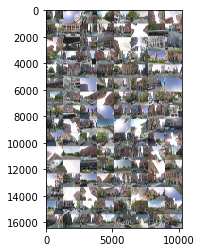

labels:  tensor([59, 95, 47, 78, 94, 57, 19, 16, 75, 62, 69, 16, 47,  2,  7, 40,  2, 78,
        14,  8, 56, 38, 30, 42, 38, 74, 37, 58, 77, 74, 69, 11, 65, 47,  1, 16,
        64, 42, 36, 73, 30, 47, 86, 90, 15, 47, 25, 22,  3, 38, 21, 91, 38, 67,
        18, 30, 34,  4,  2, 85, 77, 67, 19, 14, 13, 89, 46, 81, 87, 19, 96, 12,
        95,  0, 33, 14, 79, 13,  3, 34,  5, 99, 80, 99, 75, 90,  0, 34, 89, 58,
        16, 80, 23, 94, 32, 58, 54, 38, 73, 40, 93, 84, 23, 91,  7, 18, 31, 52,
        63, 75,  0, 32, 98, 62,  0, 45, 54, 39, 43, 27, 32, 50, 67, 69, 87, 83,
        78, 43])


In [30]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("labels: ", labels)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 253 * 317, out_features=120) # Fully Connected Layers
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=100) # out_features is the number of classes
        #LSTM
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
#         print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
#         print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out


net = Net()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1283216, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=100, bias=True)
)

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
torch.cuda.empty_cache() #Clear GPU memory

In [ ]:
EPOCHS = 1
from tqdm import tqdm
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    with tqdm(enumerate(trainloader,0), unit="batch") as tepoch:
        for i, data in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
    #         print(data)
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

print('Finished Training')

Epoch 0: : 4batch [01:46, 26.74s/batch]


KeyboardInterrupt: 

Let's quickly save our trained model:



In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
for more details on saving PyTorch models.

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        outputs = outputs.to(device)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')